# Course 4 - Project - Part 8: Convolutional neural network

<a name="top-8"></a>
This notebook is concerned with *Part 8: Convolutional neural network*.

**Contents:**
* [Step 0: Loading data](#step-8.0)
* [Step 1: Convolutional neural network](#step-8.1)

## Step 0: Loading data<a name="step-7.0"></a> ([top](#top-7))
---

We begin with some imports.

In [28]:
# Standard library.
import pathlib
import typing as T

# 3rd party.
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Project.
import utils

We will fix the seed for the PRNG in order to make computations deterministic.

In [29]:
RANDOM_SEED = 0

## Step 1: Convolutional neural network<a name="step-8.1"></a> ([top](#top-8))
---

We begin with some imports.

In [30]:
import tensorflow as tf
import tensorflow.keras as keras
from sklearn.model_selection import ParameterGrid
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras import activations
from tensorflow.keras import initializers
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import metrics
from tensorflow.keras import optimizers

**Note:** After some trying and tweaking, we decide to use the design of the model from _Subject 08 - Unit 06_. The only change is that we increase the number of hidden neurons from 256 to 1024.

In [31]:
def build_model(input_shape: T.Tuple[int, int, int],
                dropout_rate: float = 0.5,
                l2_alpha: float=0.01):
    """\
    Builds, compiles and returns a Keras model.

    .. seealso:: https://keras.io/scikit-learn-api/
    """    
    # Create model.
    model = keras.Sequential()

    # Input layer with ? x ? x 3 RGB images.
    model.add(layers.InputLayer(input_shape=input_shape))
    
    #
    # 2 Convolutional/max-pooling layers.
    #
              
    # Convolutional layer - 64 filters, kernel: 5 x 5, stride: 2 x 2, padding: "same", activation: ReLU.
    model.add(layers.Conv2D(filters=64, kernel_size=5, strides=2, padding='same', activation='relu'))

    # Maxpool layer - pool-size: 2 x 2, strides: 2 x 2, padding: "same".
    model.add(layers.MaxPooling2D(pool_size=2, strides=2, padding='same'))
              
    # Convolutional layer - 64 filters, kernel: 3 x 3, stride: 1 x 1, padding: "same", activation: ReLU.
    model.add(layers.Conv2D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu'))
    
    # Maxpool layer - pool-size: 2 x 2, stride: 2 x 2, padding: "same".
    model.add(layers.MaxPooling2D(pool_size=2, strides=2, padding='same'))

    #
    # Dropout, 2 fully connected layers.
    #
    
    model.add(layers.Flatten())     
    model.add(layers.Dropout(dropout_rate, seed=RANDOM_SEED))

    model.add(layers.Dense(
        units=1024, activation='relu',
        kernel_initializer=initializers.VarianceScaling(scale=2.0, seed=RANDOM_SEED),
        kernel_regularizer=keras.regularizers.l2(l=l2_alpha)))

    # Output layer.
    model.add(layers.Dense(
        units=6, activation='softmax',
        kernel_initializer=initializers.VarianceScaling(scale=1.0, seed=RANDOM_SEED),
        kernel_regularizer=keras.regularizers.l2(l=l2_alpha)))

    # Compile the model.
    model.compile(
        optimizer=optimizers.Adam(),  # use defaults
        loss=losses.categorical_crossentropy,
        metrics=['acc']
    )

    return model

**Note:**  In order to reduce the number of parameters in the classifier part of the model, we decide to resize images from 256 x 256 pixels down to 128 x 128 pixels. Since image are resized but kernel sizes stay the same, this must also impact the NN part of the model somewhow.

In [32]:
input_shape_2d = (128, 128)
input_shape = tuple([*input_shape_2d, 3])

We will apply the following data augmentations.

In [33]:
AUGMENTATIONS = dict(
    rotation_range=15,  # ±15 degrees
    width_shift_range=0.15,  # ±15%
    height_shift_range=0.15,  # ±15%
    brightness_range=(0.75, 1.25),  # 75% (darker) to 125% (brighter)
    zoom_range=(0.75, 1.25),  # 75% (zoom in) to 125% (zoom out)
    fill_mode='nearest',
    horizontal_flip=True
)

In [34]:
# We train from the pixels.
base_path = pathlib.Path.cwd() / 'data' / 'swissroads'
assert base_path.is_dir()

### Training on _train_ only

We begin with some imports.

In [35]:
# 3rd party.
from tensorflow.keras.callbacks import History
from tensorflow.keras.preprocessing.image import ImageDataGenerator

**Note:** For the the validation set, we decide to use the generator that does _not_ apply augmentations.

In [36]:
def plot_learning_curves(history):
    """\
    Plosts the learning curves.
    """
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

    # Plot loss values.
    ax1.set_title('loss: {:.4f}'.format(history.history['val_loss'][-1]))
    ax1.plot(history.history['val_loss'], label='validation')
    ax1.plot(history.history['loss'], label='training')
    ax1.legend()

    # Plot accuracy values.
    ax2.set_title('accuracy: {:.2f}%'.format(history.history['val_acc'][-1]*100))
    ax2.plot(history.history['val_acc'], label='validation')
    ax2.plot(history.history['acc'], label='training')
    ax2.legend()

    plt.show()

In [37]:
def train_and_evaluate(model: keras.Model) -> T.Tuple[History, T.Mapping[str, float]]:

    # Image generator with augmentations for training.
    train_generator = ImageDataGenerator(rescale=1/255, **AUGMENTATIONS)
    # Image generator without augmentations for validation and test.
    test_generator = ImageDataGenerator(rescale=1/255)

    train_set = train_generator.flow_from_directory(
        base_path / 'train', batch_size=32, target_size=input_shape_2d, shuffle=True, seed=RANDOM_SEED, interpolation='bicubic')
    valid_set = test_generator.flow_from_directory(
        base_path / 'valid', batch_size=32, target_size=input_shape_2d, shuffle=False, interpolation='bicubic')
    test_set = test_generator.flow_from_directory(
        base_path / 'test', batch_size=32, target_size=input_shape_2d, shuffle=False, interpolation='bicubic')
    
    # Trick: end training when accuracy stops improving (optional).
    early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

    # Train the model.
    history = model.fit_generator(
        generator=train_set, validation_data=valid_set, epochs=100, callbacks=[early_stopping])
    
    # Evaluate the model.
    results = dict(zip(model.metrics_names, model.evaluate_generator(test_set)))
    
    return history, results

In [38]:
dropout_rate = 0.5
l2_alpha = 0.001

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 64, 64, 64)        4864      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 16384)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 1024)              16778240  
__________

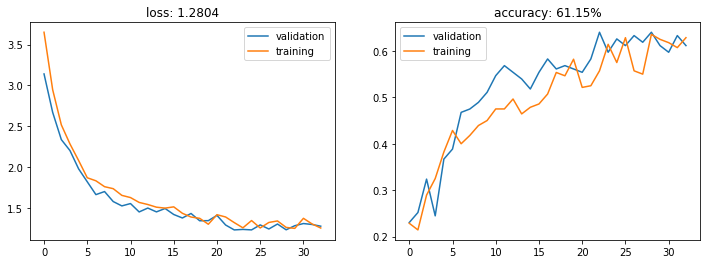

{'loss': 1.3504091024398803, 'acc': 0.64}


In [39]:
# Try to make computations deterministic.
utils.reset_seeds()

# Build and train the model.
model = build_model(input_shape, dropout_rate=dropout_rate, l2_alpha=l2_alpha)
model.summary()

# Train and evaluate the model.
history, results = train_and_evaluate(model)

# Plot the learning curves and print the accuracy on the test set.
plot_learning_curves(history)
print(results)

In [40]:
# Persist the result.
accuracy_test = results['acc']
params = dict(input_shape=input_shape, dropout_rate=dropout_rate, l2_alpha=l2_alpha)
desc = ', '.join([f'{key}={params[key]}' for key in ['input_shape', 'dropout_rate', 'l2_alpha']])
utils.persist_result('cnn', 'part-08-a', desc, accuracy_test)

**Comment:** Unlike in _Part 07_, we did not find an easy way to do a grid search using an `ImageDataGenerator`. So we slightly changed the paramameters and re-ran the above a couple fo times. In the end we settled on a `dropout_rate=0.5` and `l2_alpha=0.001`.

### Large train set

We begin with some imports.

In [41]:
# Standard library.
import os
import shutil

Having found a suitable design and set of hyperparameters, we want to figure out if we can slightly increase the accuracy by training the model on a larger training set obtained by grouping the current training and validation sets. This would typically be done for us by `GridSearchCV` with `refit=True`.

In [42]:
def merge_datasets(src_paths: T.Sequence[os.PathLike], dst_path: os.PathLike) -> None:
    n_copied = 0
    for src_path in src_paths:
        src_label_paths = [entry for entry in src_path.iterdir() if entry.is_dir()]
        for src_label_path in sorted(src_label_paths):
            label = src_label_path.name
            dst_label_path = dst_path / label
            dst_label_path.mkdir(exist_ok=True)
            src_image_paths = src_label_path.glob('*.png')
            for src_image_path in src_image_paths:
                name = src_image_path.name
                dst_image_path = dst_label_path / name
                shutil.copy2(src_image_path, dst_image_path)  # will overwrite
                n_copied += 1
    print(n_copied)

In [43]:
train_set = set(p.name for p in (base_path / 'train').glob('**/*.png'))
valid_set = set(p.name for p in (base_path / 'valid').glob('**/*.png'))
print(
    train_set.intersection(valid_set),
    len(train_set),
    len(valid_set)
)

set() 280 139


In [44]:
dst_path = base_path / 'train_large'
dst_path.mkdir(exist_ok=True)

merge_datasets([base_path / 'train', base_path / 'valid'], dst_path)

# Quick check.
path = base_path / 'train_large'
num = sum(1 for _ in path.glob('**/*.png'))
print(f'{num} images')

419
419 images


In [45]:
def train_and_evaluate_large(model: keras.Model, epochs: int = 100) -> T.Tuple[History, T.Mapping[str, float]]:

    # Image generator with augmentations for training.
    train_generator = ImageDataGenerator(rescale=1/255, **AUGMENTATIONS)
    # Image generator without augmentations for validation and test.
    test_generator = ImageDataGenerator(rescale=1/255)

    train_set = train_generator.flow_from_directory(
        base_path / 'train_large', batch_size=32, target_size=input_shape_2d, shuffle=True, seed=RANDOM_SEED, interpolation='bicubic')
    test_set = test_generator.flow_from_directory(
        base_path / 'test', batch_size=32, target_size=input_shape_2d, shuffle=False, interpolation='bicubic')
    
    # Train the model.
    history = model.fit_generator(generator=train_set, epochs=epochs)
    
    # Evaluate the model.
    results = dict(zip(model.metrics_names, model.evaluate_generator(test_set)))
    
    return history, results

In [46]:
# Try to make computations deterministic.
utils.reset_seeds()

# Build and train the model.
model_large = build_model(input_shape, dropout_rate=dropout_rate, l2_alpha=l2_alpha)
model_large.summary()

# Train and evaluate the model.
history_large, results_large = train_and_evaluate_large(model_large, epochs=80)

# Plot the learning curves.
# plot_learning_curves(history_large)
print(results_large)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 64, 64, 64)        4864      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 16384)             0         
_________________________________________________________________
dense_8 (Dense)              (None, 1024)              16778240  
__________

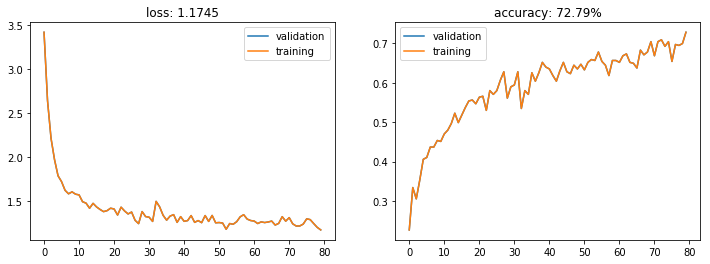

In [47]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# Plot loss values
ax1.set_title('loss: {:.4f}'.format(history_large.history['loss'][-1]))
ax1.plot(history_large.history['loss'], label='validation')
ax1.plot(history_large.history['loss'], label='training')
ax1.legend()

# plot accuracy values
ax2.set_title('accuracy: {:.2f}%'.format(history_large.history['acc'][-1]*100))
ax2.plot(history_large.history['acc'], label='validation')
ax2.plot(history_large.history['acc'], label='training')
ax2.legend()

plt.show()

In [48]:
results_large

{'loss': 1.2503688764572143, 'acc': 0.7000000011920929}

In [49]:
# Persist the result.
accuracy_test = results_large['acc']
params = dict(input_shape=input_shape, dropout_rate=dropout_rate, l2_alpha=l2_alpha)
desc = ', '.join([f'{key}={params[key]}' for key in ['input_shape', 'dropout_rate', 'l2_alpha']])
utils.persist_result('cnn-refit', 'part-08-b', desc, accuracy_test)

**Q: What accuracy can you achieve?**

A: By refitting the model on the training + validation sets, we achieve 70% accuracy on the test set.

**Q: Can you get good results? - If not, why?**

A: The MobileNet v2 CNN model from TensorFlow Hub was probably trained on millions of images. Here by using the training + validation sets we have only 419 images available. Even with data augmentations, this is most likely not enough.